# Judge Hiciano Jupyter Notebook

In [338]:
# Imports required for project
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk

# Plotting
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from pprint import pprint

# sklearn Metrics and tunning
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#import machine learning related libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb



In [339]:
pd.options.display.max_rows = 50000
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)

## Description of variables
• sessionID: Session ID. 1-50000 in train.csv, 50001-55111 in test.csv.

• hour: Hour when the session was started. Numbers between 0 and 23.

• weekday: Day of the week when the session was started. 5: Friday, 6: Saturday, 7: Sunday, 1: Monday.

• duration: Time in seconds passed since the start of the session.

• clickCount: Number of products that were visited (clicked).

• clickMin: Lowest price of the products visited (clicked).

• clickMax: Highest price of the products visited (clicked).

• clickTotal: Sum of the prices of all the products visited (clicked).

• cartCount: Number of products that were added to the cart.

• cartMin: Lowest price of the products in the cart.

• cartMax: Highest price of the products in the cart.

• cartTotal: Sum of the prices of all the products in the cart.

• cartStep: Purchase processing step. Possible values: 1,2,3,4,5.

• status: Whether the customer is online. ‘y’: yes. ‘n’: no.

• availability: Whether the cart is orderable or not. There are seven possible values.

• customerID: customer ID. 1-25038 in train.csv. In test.csv there exist both old and new customers.

• purchase: Highest purchase price in history for the customer.

• score: Customer score evaluated by the online store.

• account: Lifetime of the customer’s account in months.

• payments: Number of payments made by the customer.

• age: Age of the customer.

• salutation: Salutation of the customer. 1: Mr, 2: Ms, 3: Company.

• lastOrder: Time in days passed since the last order.

• order: (Response variable) Whether the order is placed. ‘y’: yes. ‘n’: no.


In [340]:
df_train = pd.read_csv("../data/train.csv") 
df_test = pd.read_csv("../data/test.csv")


In [341]:
print(len(df_train))
df_train['sess_count'] = df_train.groupby('sessionID')['sessionID'].transform('count')
df_train['total_duration'] = df_train.groupby('sessionID')['duration'].transform('sum')
df_train.loc[df_train['customerID'] >= 0,'is_customer'] = 1
df_train['is_customer'].fillna(0, inplace=True)
df_train['cartStep'].fillna(0, inplace=True)
df_train['missing_items_total'] = df_train['clickTotal']-df_train['cartTotal']
df_train['ordered'] = (df_train['order'] !='n').astype(int) #Converts string `order` to int value for training
df_train.dropna(thresh=16,inplace=True)
print(len(df_train))
df_train.head(2)


429013
426768


,sessionID,hour,weekday,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,status,availability,customerID,purchase,score,account,payments,age,salutation,lastOrder,order,sess_count,total_duration,is_customer,missing_items_total,ordered
0,1,6,5,0.00,1,59.99,59.99,59.99,1,59.99,59.99,59.99,0.0,NaN,NaN,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y,3,51.827,1.0,0.0,1
1,1,6,5,11.94,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,y,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y,3,51.827,1.0,0.0,1


sns.pairplot(df_train, hue="ordered")

In [289]:
dfxx = df_train.groupby(['score','order'])['order'].count()
dfxx.head(5)

score  order
-1.0   n        79532
       y        71963
 0.0   n        12   
       y        57   
 1.0   n        26   
Name: order, dtype: int64

In [288]:
df_train['score'].fillna(-1, inplace=True)
dfxx = df_train.groupby(['score','order'])['order'].count()
dfxx.head(5)

score  order
-1.0   n        79532
       y        71963
 0.0   n        12   
       y        57   
 1.0   n        26   
Name: order, dtype: int64

In [282]:
dfxx = df_train.groupby(['is_customer','order'])['order'].count()
dfxx.head(500)

is_customer  order
0.0          n        78735 
             y        70118 
1.0          n        58625 
             y        219290
Name: order, dtype: int64

In [342]:
df_test['score'].fillna(-1, inplace=True)
df_test['sess_count'] = df_test.groupby('sessionID')['sessionID'].transform('count')
df_test['total_duration'] = df_test.groupby('sessionID')['duration'].transform('sum')
df_test['missing_items_total'] = df_test['clickTotal']-df_test['cartTotal']

df_test.loc[df_test['customerID'] >= 0,'is_customer'] = 1
df_test['is_customer'].fillna(0, inplace=True)

df_test.describe()

,sessionID,hour,weekday,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,total_duration,missing_items_total,is_customer
count,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,44742.000000,44742.000000,44742.000000,45068.000000,44479.000000,44479.000000,44479.000000,24302.000000,27804.000000,27616.000000,45068.000000,27616.000000,27804.000000,27786.000000,27804.000000,27804.000000,45068.000000,4.506800e+04,44479.000000,45068.000000
mean,52385.701185,18.589509,6.458418,1645.291183,27.316810,53.299304,149.135132,1240.985675,4.366668,65.935684,105.750478,209.595122,2.240844,25236.189433,2039.006373,294.743033,129.780997,9.951014,43.281941,1.744497,94.915264,17.163486,3.847433e+04,1033.120793,0.616934
std,1426.206838,5.543531,1.719373,2279.003964,32.549188,146.774665,272.250373,3523.665302,4.333860,172.340996,204.394800,414.707600,1.284694,4087.158333,2157.553606,259.960288,104.308406,13.388516,11.526591,0.439028,125.050807,13.240240,7.956577e+04,3272.518633,0.486139
min,50001.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,47.000000,0.000000,-1.000000,0.000000,0.000000,17.000000,1.000000,4.000000,1.000000,0.000000e+00,0.000000,0.000000
25%,51166.000000,19.000000,7.000000,259.884500,6.000000,5.000000,29.990000,154.370000,1.000000,7.990000,19.990000,39.990000,1.000000,25478.000000,600.000000,-1.000000,43.000000,2.000000,35.000000,1.000000,16.000000,8.000000,3.768789e+03,79.940000,0.000000
50%,52331.000000,20.000000,7.000000,864.808000,15.000000,9.990000,49.990000,445.540000,3.000000,12.990000,34.990000,89.970000,2.000000,26090.000000,1200.000000,457.000000,102.000000,7.000000,43.000000,2.000000,42.000000,14.000000,1.373283e+04,313.830000,1.000000
75%,53600.000000,21.000000,7.000000,2148.555000,36.000000,24.990000,99.990000,1164.570000,6.000000,29.990000,69.990000,209.850000,3.000000,26681.000000,3000.000000,537.000000,213.000000,13.000000,50.000000,2.000000,123.000000,22.000000,4.018059e+04,933.250000,1.000000
max,55111.000000,23.000000,7.000000,21320.113000,200.000000,1999.990000,4799.000000,117310.700000,43.000000,1999.990000,2299.990000,8948.960000,5.000000,27318.000000,25000.000000,614.000000,524.000000,278.000000,90.000000,3.000000,733.000000,87.000000,1.172623e+06,108950.790000,1.000000


In [343]:
common_drops = ['sessionID',
                'customerID',
                'weekday',
                 'status',
                'availability',
#                 'cartStep',
                 'purchase',
#                 'score',                 
                'payments',
                'account',
                'lastOrder',
                 'salutation',
                 'age',
#                 'cartCount',
#                 'clickMin',
#                 'cartMin',
                 'hour',
#                 'duration',
#                 'clickCount',
#                 'clickMax',
#                 'cartMax',
#                 'clickTotal',
#                 'cartTotal'
               ]
drop_columns_train = ['order']+ common_drops
drop_columns_submission = []+common_drops

In [344]:
df_test_cl = df_test.drop(drop_columns_submission,axis=1)
df_test_cl = pd.get_dummies(df_test_cl)
#df_test_cl = df_test_cl.drop('status_n',axis=1)
df_test_cl =pd.DataFrame(df_test_cl).fillna(0)
len(df_test_cl)

45068

In [346]:
df_test_cl.head(100)

,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,score,sess_count,total_duration,missing_items_total,is_customer
0,136.833,3,39.99,39.99,79.98,1,39.99,39.99,39.99,2.0,489.0,9,3761.542,39.99,1.0
1,189.984,3,39.99,39.99,79.98,1,39.99,39.99,39.99,0.0,489.0,9,3761.542,39.99,1.0
2,342.894,6,16.99,39.99,113.96,2,16.99,39.99,56.98,0.0,489.0,9,3761.542,56.98,1.0
3,411.051,8,16.99,39.99,149.94,3,16.99,39.99,74.97,0.0,489.0,9,3761.542,74.97,1.0
4,460.049,10,16.99,39.99,189.92,4,16.99,39.99,94.96,0.0,489.0,9,3761.542,94.96,1.0
5,471.502,10,16.99,39.99,189.92,4,16.99,39.99,94.96,1.0,489.0,9,3761.542,94.96,1.0
6,560.026,11,16.99,39.99,207.91,5,16.99,39.99,112.95,0.0,489.0,9,3761.542,94.96,1.0
7,564.597,11,16.99,39.99,207.91,5,16.99,39.99,112.95,1.0,489.0,9,3761.542,94.96,1.0
8,624.606,11,16.99,39.99,207.91,5,16.99,39.99,112.95,0.0,489.0,9,3761.542,94.96,1.0
9,133.321,7,34.99,34.99,69.98,1,34.99,34.99,34.99,0.0,543.0,11,14046.089,34.99,1.0


## Feature Enigneering on Training Data

Currently droping 'order', 'sessionID', and 'age' 

In [293]:
q = df_train["sess_count"].quantile(0.99)
df_train = df_train[df_train["sess_count"] < q]
df_train['ordered'] = (df_train['order'] !='n').astype(int) #Converts string `order` to int value for training
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422430 entries, 0 to 429012
Data columns (total 29 columns):
sessionID              422430 non-null int64
hour                   422430 non-null int64
weekday                422430 non-null int64
duration               422430 non-null float64
clickCount             422430 non-null int64
clickMin               421851 non-null float64
clickMax               421851 non-null float64
clickTotal             421851 non-null float64
cartCount              422430 non-null int64
cartMin                419632 non-null float64
cartMax                419632 non-null float64
cartTotal              419632 non-null float64
cartStep               422430 non-null float64
status                 264183 non-null object
availability           259415 non-null object
customerID             274824 non-null float64
purchase               272182 non-null float64
score                  422430 non-null float64
account                272182 non-null float64
payments

In [327]:
df_train_clensed = df_train.drop(drop_columns_train,axis=1)
df_train_clensed = pd.get_dummies(df_train_clensed)
# # df_train_clensed = df_train_clensed.drop('status_n', axis =1 )
# df_train_clensed.head()
# df_train_clensed.dropna(thresh=4,inplace=True)
df_train_clensed =pd.DataFrame(df_train_clensed).fillna(0)
print(len(df_train_clensed))
df_train_clensed.info()

426768
<class 'pandas.core.frame.DataFrame'>
Int64Index: 426768 entries, 0 to 429012
Data columns (total 16 columns):
duration               426768 non-null float64
clickCount             426768 non-null int64
clickMin               426768 non-null float64
clickMax               426768 non-null float64
clickTotal             426768 non-null float64
cartCount              426768 non-null int64
cartMin                426768 non-null float64
cartMax                426768 non-null float64
cartTotal              426768 non-null float64
cartStep               426768 non-null float64
score                  426768 non-null float64
sess_count             426768 non-null int64
total_duration         426768 non-null float64
is_customer            426768 non-null float64
missing_items_total    426768 non-null float64
ordered                426768 non-null int64
dtypes: float64(12), int64(4)
memory usage: 75.4 MB


In [316]:
df_train_clensed.describe()

,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,score,sess_count,total_duration,is_customer,missing_items_total,ordered
count,426768.000000,426768.000000,426184.000000,426184.000000,426184.000000,426768.000000,423883.000000,423883.000000,423883.000000,426768.000000,275273.000000,426768.000000,4.267680e+05,426768.000000,423883.000000,426768.000000
mean,1580.841383,24.261170,55.282631,146.641196,1189.156535,4.153503,67.625341,107.505057,213.260809,1.270325,485.298449,16.789801,3.814171e+04,0.651209,972.585354,0.678139
std,2431.064096,30.430687,148.876290,283.204317,3371.233096,4.454680,174.986371,212.916300,459.389852,1.498087,131.027630,14.929797,1.127337e+05,0.476588,3084.593260,0.467191
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,229.402750,5.000000,6.990000,25.950000,137.960000,1.000000,8.990000,19.990000,39.990000,0.000000,481.000000,8.000000,3.089490e+03,0.000000,62.990000,0.000000
50%,743.948000,13.000000,12.000000,49.990000,388.200000,3.000000,14.990000,39.990000,87.970000,1.000000,520.000000,13.000000,1.131264e+04,1.000000,269.990000,1.000000
75%,1889.129750,31.000000,29.990000,99.990000,1046.430000,5.000000,34.990000,79.790000,205.380000,2.000000,555.000000,21.000000,3.517535e+04,1.000000,814.845000,1.000000
max,21580.092000,200.000000,5999.990000,6999.990000,115742.000000,108.000000,6999.990000,6999.990000,23116.880000,5.000000,638.000000,257.000000,3.221057e+06,1.000000,103453.000000,1.000000


In [317]:
df_test_cl.describe()

,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,score,sess_count,total_duration,missing_items_total,is_customer
count,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,4.506800e+04,45068.000000,45068.000000
mean,1645.291183,27.316810,52.913763,148.056361,1232.008988,4.366668,65.073961,104.368410,206.855894,1.208330,295.130270,17.163486,3.847433e+04,1019.618792,0.616934
std,2279.003964,32.549188,146.312575,271.558145,3512.472334,4.333860,171.374780,203.409628,412.675805,1.462052,259.519823,13.240240,7.956577e+04,3253.179972,0.486139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000
25%,259.884500,6.000000,5.000000,29.950000,149.957500,1.000000,7.000000,19.990000,39.980000,0.000000,0.000000,8.000000,3.768789e+03,70.315000,0.000000
50%,864.808000,15.000000,9.990000,49.990000,438.780000,3.000000,12.990000,34.990000,87.985000,1.000000,457.000000,14.000000,1.373283e+04,304.920000,1.000000
75%,2148.555000,36.000000,24.990000,99.990000,1159.840000,6.000000,29.990000,69.990000,205.900000,2.000000,537.000000,22.000000,4.018059e+04,917.885000,1.000000
max,21320.113000,200.000000,1999.990000,4799.000000,117310.700000,43.000000,1999.990000,2299.990000,8948.960000,5.000000,614.000000,87.000000,1.172623e+06,108950.790000,1.000000


sns.relplot(x="score", y="purchase", col="salutation",
            hue="ordered", #, style="smoker", size="order",
            data=df_train);

sns.relplot(x="sessionID",y="sess_count",
            hue="ordered", #, style="smoker", size="order",
            data=df_train);

corr = df_train_clensed[df_train_clensed.columns].corr()
plt.figure(figsize = (50,50))
sns.heatmap(corr, annot = True, linewidths=0.1, fmt=".1f");

corr = df_test_cl[df_test_cl.columns].corr()
plt.figure(figsize = (50,50))
sns.heatmap(corr, annot = True, linewidths=0.1, fmt=".1f");

In [347]:
X, y = df_train_clensed.drop(['ordered'],axis=1), df_train_clensed.ordered
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=68)

In [172]:
#create an array of models as base to see what has highest base score to select for tuning
models = []

models.append(("RF",RandomForestClassifier()))
models.append(("RF Tunned",RandomForestClassifier(max_depth = 35,
                                                  n_estimators= 40,
                                                  random_state=0,
                                                  max_features='auto',
                                                  bootstrap=False,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2)))
models.append(("Dtree",AdaBoostClassifier()))
models.append(("XGB",xgb.XGBClassifier()))


#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=7, random_state=22, shuffle=True)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold, scoring = "accuracy")
    print(name, cv_result)

RF [0.95057175 0.95015968 0.95219846 0.95104463 0.94857213 0.9513949
 0.95170396]
RF Tunned [0.95096322 0.95050994 0.95147731 0.95137429 0.94873697 0.95131248
 0.95174517]
Dtree [0.76820851 0.76664263 0.76659661 0.76824494 0.76740017 0.76542218
 0.7690279 ]
XGB [0.81429896 0.81747193 0.81456299 0.81687065 0.81942556 0.81221412
 0.81633494]


Source for Parameter running randomforest:
    
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

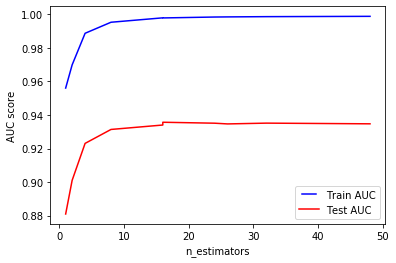

In [143]:
from sklearn.metrics import roc_curve, auc
n_estimators = [1, 2, 4, 8, 16, 19,24,26, 32,48]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

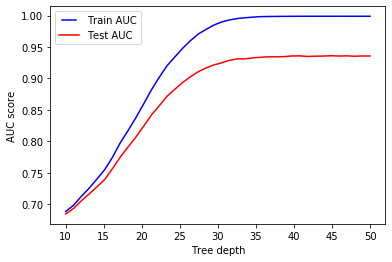

In [144]:
max_depths = np.linspace(10, 50, 40, endpoint=True)
train_results = []
test_results = []

# Loop through each of the max depths and train
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results,'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [334]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 50, num = 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 40)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3,4,5, 10,]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 6, 8]
# Method of selecting samples for training each tree
bootstrap = [True]
oob_score=[True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'oob_score': oob_score
              }


In [335]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rc_random = RandomizedSearchCV(estimator = rc,
                               param_distributions = random_grid,
                               n_iter = 50,
                               cv = 7,
                               verbose=5,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
rc_random.fit(X_train, y_train)

Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 44.3min finished


RandomizedSearchCV(cv=7, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [336]:
rc_random.best_params_

{'oob_score': True,
 'n_estimators': 44,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 41,
 'bootstrap': True}

In [348]:
clf2 = RandomForestClassifier(class_weight="balanced",
                              oob_score=True,
                              max_depth = 30,
                              n_estimators= 18,
                              random_state=0,
                              max_features='sqrt',
                              bootstrap=True,
                              min_samples_leaf=1,
                              min_samples_split=3)
clf2.fit(X_train, y_train)
print(clf2.feature_importances_)
df_test_cl.describe()

[0.06007207 0.04820609 0.05720658 0.05688085 0.06030657 0.03183375
 0.05392311 0.05130715 0.05778504 0.03321617 0.09442842 0.16959196
 0.11699243 0.04995277 0.05829705]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,score,sess_count,total_duration,missing_items_total,is_customer
count,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,4.506800e+04,45068.000000,45068.000000
mean,1645.291183,27.316810,52.913763,148.056361,1232.008988,4.366668,65.073961,104.368410,206.855894,1.208330,294.743033,17.163486,3.847433e+04,1019.618792,0.616934
std,2279.003964,32.549188,146.312575,271.558145,3512.472334,4.333860,171.374780,203.409628,412.675805,1.462052,259.960288,13.240240,7.956577e+04,3253.179972,0.486139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000e+00,0.000000,0.000000
25%,259.884500,6.000000,5.000000,29.950000,149.957500,1.000000,7.000000,19.990000,39.980000,0.000000,-1.000000,8.000000,3.768789e+03,70.315000,0.000000
50%,864.808000,15.000000,9.990000,49.990000,438.780000,3.000000,12.990000,34.990000,87.985000,1.000000,457.000000,14.000000,1.373283e+04,304.920000,1.000000
75%,2148.555000,36.000000,24.990000,99.990000,1159.840000,6.000000,29.990000,69.990000,205.900000,2.000000,537.000000,22.000000,4.018059e+04,917.885000,1.000000
max,21320.113000,200.000000,1999.990000,4799.000000,117310.700000,43.000000,1999.990000,2299.990000,8948.960000,5.000000,614.000000,87.000000,1.172623e+06,108950.790000,1.000000


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 18,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


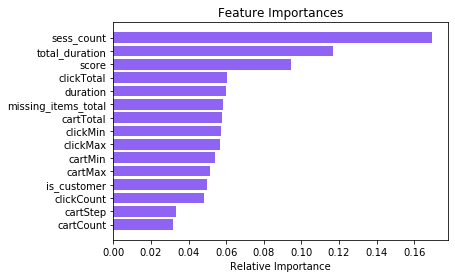

In [349]:
features = X_train.columns.values
importances = clf2.feature_importances_
indices = np.argsort(importances)
pprint(clf2.get_params())
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [350]:
clf2.score(X_test, y_test)

0.9480867914801884

In [332]:
len(X_train)
df_test_cl.head()

,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,score,sess_count,total_duration,missing_items_total,is_customer
0,136.833,3,39.99,39.99,79.98,1,39.99,39.99,39.99,2.0,489.0,9,3761.542,39.99,1.0
1,189.984,3,39.99,39.99,79.98,1,39.99,39.99,39.99,0.0,489.0,9,3761.542,39.99,1.0
2,342.894,6,16.99,39.99,113.96,2,16.99,39.99,56.98,0.0,489.0,9,3761.542,56.98,1.0
3,411.051,8,16.99,39.99,149.94,3,16.99,39.99,74.97,0.0,489.0,9,3761.542,74.97,1.0
4,460.049,10,16.99,39.99,189.92,4,16.99,39.99,94.96,0.0,489.0,9,3761.542,94.96,1.0


In [353]:
df_test_cl.head(100)

,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,score,sess_count,total_duration,missing_items_total,is_customer
0,136.833,3,39.99,39.99,79.98,1,39.99,39.99,39.99,2.0,489.0,9,3761.542,39.99,1.0
1,189.984,3,39.99,39.99,79.98,1,39.99,39.99,39.99,0.0,489.0,9,3761.542,39.99,1.0
2,342.894,6,16.99,39.99,113.96,2,16.99,39.99,56.98,0.0,489.0,9,3761.542,56.98,1.0
3,411.051,8,16.99,39.99,149.94,3,16.99,39.99,74.97,0.0,489.0,9,3761.542,74.97,1.0
4,460.049,10,16.99,39.99,189.92,4,16.99,39.99,94.96,0.0,489.0,9,3761.542,94.96,1.0
5,471.502,10,16.99,39.99,189.92,4,16.99,39.99,94.96,1.0,489.0,9,3761.542,94.96,1.0
6,560.026,11,16.99,39.99,207.91,5,16.99,39.99,112.95,0.0,489.0,9,3761.542,94.96,1.0
7,564.597,11,16.99,39.99,207.91,5,16.99,39.99,112.95,1.0,489.0,9,3761.542,94.96,1.0
8,624.606,11,16.99,39.99,207.91,5,16.99,39.99,112.95,0.0,489.0,9,3761.542,94.96,1.0
9,133.321,7,34.99,34.99,69.98,1,34.99,34.99,34.99,0.0,543.0,11,14046.089,34.99,1.0


In [355]:
results = clf2.predict(df_test_cl)

## Get results as csv

1. I create a dataframe with the sessionsID from the test dataset and join it to the results to get a dataframe `"sessionId","order"`. Then we have to  flatten the sessionIds are we get duplicates. 
1. I  sort by order , 1s would be first for a given session ID and then drop all the duplicates
1. I then convert the 1 to y and 0 to n for oder
1. last step is writing out to a csv file

In [356]:
df_results = pd.DataFrame({"sessionID":df_test.sessionID, "order_int":results})
df_results.sort_values(by=['order_int'], ascending=False)
df_dist  = df_results.drop_duplicates(subset = "sessionID", )
df_dist.head()

,sessionID,order_int
0,50001,1
9,50002,1
20,50003,1
43,50004,1
49,50005,0


In [335]:
df_dist.loc[df_dist['order_int']==1,'order'] = 'y'
df_dist['order'].fillna('n', inplace=True)
df_final = df_dist.drop('order_int',axis=1)
df_final.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pan

,sessionID,order
0,50001,y
9,50002,y
20,50003,y
43,50004,y
49,50005,n


In [336]:
df_final.to_csv("../data/results.csv", index=False)

Automatically created module for IPython interactive environment


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

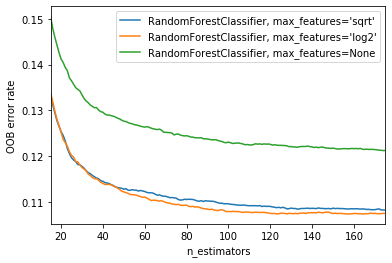

In [100]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 30
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()